# RGB 3D CNN

Architecture: `TODO: make drawing`

In [0]:
#@markdown Run this cell to mount Google Drive.

!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
root = '/content/drive/MSRDailyActivity3D'
os.chdir(root)

## Read & split dataset

[MSR Daily Activity 3D](http://users.eecs.northwestern.edu/~jwa368/my_data.html) dataset contains: 16 activities, performed twice (once standing, once sitting), by 10 subjects. Out of these 16 activities, only 9 are used, because the others are depicted by videos that are considered to be too short (i.e. shorter than 4 seconds).<br>
**Split** it as it follows:

* training set: 5 people (50%) = first 5 x 2 videos of each class
* validation set: 2 people (20%)
* testing set: 3 people (30%) = last 3 x 2 videos of each class

In [0]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

# Loading the data
raw_data = load_files(os.getcwd() + r'/RGB')
files = raw_data['filenames']
targets = raw_data['target']

# Generic details about the data
print('Total number of videos:', len(files))

Total number of videos: 180


In [0]:
train_files, train_targets, validation_files, validation_targets, \
test_files, test_targets = ([] for i in range(6))

count = 0
for file, target in zip(files, targets):
    count += 1
    if count <= 10:
        train_files.append(file)
        train_targets.append(target)
    elif count <= 14:
        validation_files.append(file)
        validation_targets.append(target)
    else:
        test_files.append(file)
        test_targets.append(target)
    if count == 20:
        count = 0


# Testing...

print('Number of videos in training data:', len(train_files))
print('Number of videos in validation data:', len(validation_files))
print('Number of videos in test data:', len(test_files))

Number of videos in training data: 90
Number of videos in validation data: 36
Number of videos in test data: 54


In [0]:
# Mapping of class labels to integers.
no_activities = 9
activities = {}

for id, name in zip(range(no_activities), raw_data['target_names']):
    activities[id] = name

print(activities)

{0: 'call cellphone', 1: 'eat', 2: 'play game', 3: 'play guitar', 4: 'read book', 5: 'use laptop', 6: 'use vacuum cleaner', 7: 'walking', 8: 'write on a paper'}


In [0]:
#@markdown Run this cell to import helper class `Videos`.

import matplotlib.pyplot as plt
%matplotlib inline

def plotImages(images_arr):
    fig, axes = plt.subplots(4, 6, figsize=(10, 6))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape((SIZE, SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

!pip3 install sk-video

import numpy as np
from skvideo.io import FFmpegReader, ffprobe
from skvideo.utils import rgb2gray
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm


class Videos(object):

    def __init__(self, target_size=None, to_gray=True, max_frames=None,
                 extract_frames='middle', required_fps=None,
                 normalize_pixels=None):
        """
        Initializing the config variables
        Parameters:
            target_size (tuple): (New_Width, New_Height), Default 'None'
                A tuple denoting the target width and height of each frame in each of the video
            to_gray (boolean): Default 'True'
                If True, then each frame will be converted to gray scale. Otherwise, not.
            max_frames (int): Default 'None'
                The maximum number of frames to return for each video.
                Extra frames are removed based on the value of 'extract_frames'.
            extract_frames (str): {'first', 'middle', 'last'}, Default 'middle'
                'first': Extract the first 'N' frames
                'last': Extract the last 'N' frames
                'middle': Extract 'N' frames from the middle
                    Remove ((total_frames - max_frames) // 2) frames from the beginning as well as the end
            required_fps (int): Default 'None'
                Capture 'N' frame(s) per second from the video.
                Only the first 'N' frame(s) for each second in the video are captured.
            normalize_pixels (tuple/str): Default 'None'
                If 'None', the pixels will not be normalized.
                If a tuple - (New_min, New_max) is passed, Min-max Normalization will be used.
                If the value is 'z-score', then Z-score Normalization will be used.
                For each pixel p, z_score = (p - mean) / std
        """

        self.target_size = target_size
        self.to_gray = to_gray
        self.max_frames = max_frames
        self.extract_frames = extract_frames
        self.required_fps = required_fps
        self.normalize_pixels = normalize_pixels
        self.fps = None

    def read_videos(self, paths):
        """
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)
        """

        list_of_videos = [
            self._read_video(path) for path in tqdm(paths)
        ]
		
        tensor = np.vstack(list_of_videos)

        if self.normalize_pixels != None:
            # Pixels are normalized for each video individually
            if (type(self.normalize_pixels) == tuple) and (len(self.normalize_pixels) == 2):
                base = self.normalize_pixels[0]
                r = self.normalize_pixels[1] - base
                min_ = np.min(tensor, axis=(1, 2, 3), keepdims=True)
                max_ = np.max(tensor, axis=(1, 2, 3), keepdims=True)
                return ((tensor.astype('float32') - min_) / (max_ - min_)) * r + base

            elif self.normalize_pixels == 'z-score':
                mean = np.mean(tensor, axis=(1, 2, 3), keepdims=True)
                std = np.std(tensor, axis=(1, 2, 3), keepdims=True)
                return (tensor.astype('float32') - mean) / std
            
            else:
                raise ValueError('Invalid value of \'normalize_pixels\'')

        return tensor

    def get_frame_count(self, paths):
        """
        Can be used to determine the value of `max_frames`
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read
        Returns:
            dict (python dictionary)
                For each video, the total number of frames in that video is stored in the dictionary.
        """

        frame_count = {}
        for path in paths:
            cap = FFmpegReader(filename=path)
            frame_count[path] = cap.inputframenum
            cap.close()

        return frame_count

    def _read_video(self, path):
        """
        Parameters:
            path (str): Required
                Path of the video to be read
        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (1, <No. of frames>, <height>, <width>, <channels>)
        """

        cap = FFmpegReader(filename=path)
        list_of_frames = []
        self.fps = int(cap.inputfps)                  # Frame Rate

        for index, frame in enumerate(cap.nextFrame()):

            capture_frame = True
            if self.required_fps != None:
                is_valid = range(self.required_fps)
                capture_frame = (index % self.fps) in is_valid

            if capture_frame:

                if self.target_size is not None:
                    temp_image = image.array_to_img(frame)
                    frame = image.img_to_array(
                        temp_image.resize(
                            self.target_size,
                            Image.ANTIALIAS)).astype('uint8')

                # Shape of each frame -> (<height>, <width>, 3)
                list_of_frames.append(frame)

        temp_video = np.stack(list_of_frames)
        cap.close()

        if self.to_gray:
            temp_video = rgb2gray(temp_video)
                
        if self.max_frames is not None:
            temp_video = self._process_video(video=temp_video)

        return np.expand_dims(temp_video, axis=0)

    def _process_video(self, video):
        """
        Parameters:
            video (Numpy.ndarray):
                Shape = (<No. of frames>, <height>, <width>, <channels>)
                Video whose frames are to be extracted
        Returns:
            Numpy.ndarray
                A tensor (processed video) with shape (<`max_frames`>, <height>, <width>, <channels>)
        """

        total_frames = video.shape[0]
        if self.max_frames <= total_frames:

            if self.extract_frames == 'first':
                video = video[:self.max_frames]
            elif self.extract_frames == 'last':
                video = video[(total_frames - self.max_frames):]
            elif self.extract_frames == 'middle':
                # No. of frames to remove from the front
                front = ((total_frames - self.max_frames) // 2) + 1
                video = video[front:(front + self.max_frames)]
            else:
                raise ValueError('Invalid value of \'extract_frames\'')

        else:
            raise IndexError(
                'Required number of frames is greater than the total number of frames in the video')

        return video

    100% |████████████████████████████████| 2.3MB 11.4MB/s 


Using TensorFlow backend.


## Data pre-processing
Apply the following transformations:
* resize videos to 128x128 pixels
* extract 24 frames (from the middle) of each video
* normalize pixels (using `z-score` function)
* [one-hot encode](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) class labels (use Keras's `to_categorical()` function)
* convert frames to grayscale

The obtained tensors are of size `(no_videos, no_frames, frame_height, frame_width, no_channels)`.

In [0]:
SIZE = 128
NFRAMES = 24

def get_reader():
    return Videos(target_size=(SIZE, SIZE), 
                  to_gray=True, 
                  max_frames=NFRAMES, 
                  extract_frames='middle',
                  required_fps=6,
                  normalize_pixels='z-score')

In [0]:
from keras.utils import to_categorical

reader = get_reader()

X_train = reader.read_videos(train_files)
y_train = to_categorical(train_targets, num_classes=no_activities)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

X_valid = reader.read_videos(validation_files)
y_valid = to_categorical(validation_targets, num_classes=no_activities)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)

X_test = reader.read_videos(test_files)
y_test = to_categorical(test_targets, num_classes=no_activities)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

  0%|          | 0/36 [00:00<?, ?it/s]

Shape of training data: (90, 24, 128, 128, 1)
Shape of training labels: (90, 9)


  0%|          | 0/54 [00:00<?, ?it/s]

Shape of validation data: (36, 24, 128, 128, 1)
Shape of validation labels: (36, 9)


100%|██████████| 54/54 [02:07<00:00,  2.13s/it]


Shape of testing data: (54, 24, 128, 128, 1)
Shape of testing labels: (54, 9)


Activity: call cellphone


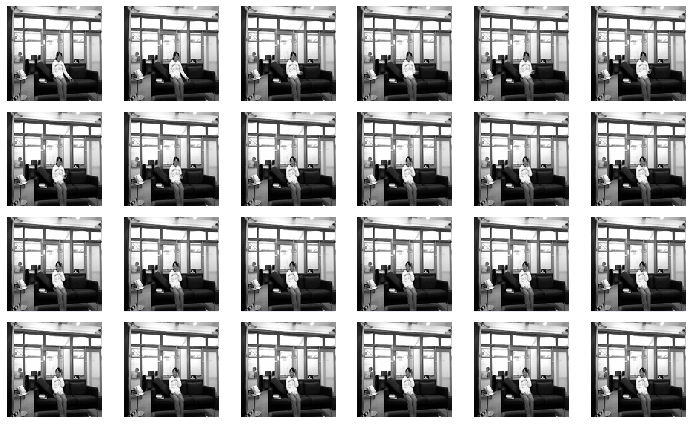

In [0]:
#@title Train data vizualization { run: "auto", display-mode: "form" }
video_id = 23 #@param {type:"slider", min:1, max:90, step:1}

print("Activity: " + activities[np.nonzero(y_train[video_id - 1])[0][0]])
plotImages(X_train[video_id - 1])

### Data augmentation

In [0]:
import imgaug as ia
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Affine(scale={"x": 1.5, "y": 1.5},),
               #translate_percent={"y": -0.2}),
    #iaa.Fliplr(0.5), # Flip 50% of the images.
    #sometimes(iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
    #                     translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
    #                     rotate =(-20, 20),
    #                     shear = (-10, 10),
    #)),
    #sometimes(iaa.GaussianBlur(sigma=(0, 1.5))),
])

def augment_video(video):
    seqDet = seq.to_deterministic()
    new_video = np.zeros((NFRAMES, SIZE, SIZE, 1))
    
    for i in range(NFRAMES):
        new_video[i] = seqDet.augment_image(video[i])
    
    return new_video

Activity: play game


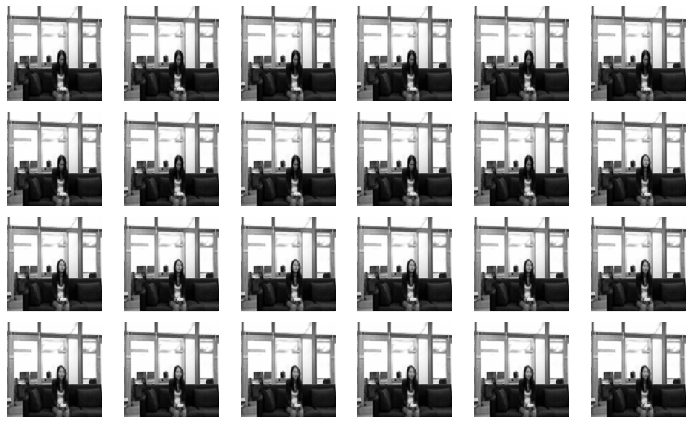

In [0]:
#@title Augmented train data vizualization { run: "auto", display-mode: "form" }
video_id = 7 #@param {type:"slider", min:1, max:90, step:1}

print("Activity: " + activities[np.nonzero(y_train[video_id - 1])[0][0]])
plotImages(augment_video(X_train[video_id - 1]))

In [0]:
import random

def image_generator(videos, labels, batch_size):
    no_videos = len(videos)
    
    while True:
        # Select batch_size random videos from the dataset.
        batch_indices = random.sample(range(0, no_videos), batch_size)
        batch_input = []
        batch_output = [] 

        # Apply data augmentation to videos and store the modified video, along
        # with its matching label.
        for i in batch_indices:
            batch_input += [augment_video(videos[i])]
            batch_output += [labels[i]]

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield(batch_x, batch_y)

## Model

In [0]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization, Activation, Flatten
from keras.layers.core import Dense, Dropout

def get_model(input_shape=(24, 128, 128, 1), no_activities=9):
    # Using the Sequential Model
    model = Sequential()

    # Adding Alternate convolutional and pooling layers
    model.add(Conv3D(filters=8, kernel_size=(5, 3, 3), strides=(1, 1, 1),
                     padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

    model.add(Conv3D(filters=16, kernel_size=(2, 3, 3), strides=(1, 1, 1),
                     padding='valid', activation='relu'))
    model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

    model.add(Conv3D(filters=64, kernel_size=(2, 3, 3), strides=(1, 1, 1),
                     padding='valid', activation='relu'))
    model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

    model.add(Conv3D(filters=256, kernel_size=(2, 3, 3), strides=(1, 1, 1),
                     padding='valid', activation='relu'))
    model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

    # A global average pooling layer to get a 1-d vector
    # The vector will have a depth (same as number of elements in the vector) of 256.
    model.add(GlobalAveragePooling3D())

    # Hidden layer
    model.add(Dense(32, activation='relu'))

    # Dropout Layer
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(no_activities, activation='softmax'))

    return model


# Testing...
get_model().summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 24, 128, 128, 8)   368       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 64, 64, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 11, 62, 62, 16)    2320      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 31, 31, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 5, 29, 29, 64)     18496     
_________________________________________________________________
max_pooling3d_3 (MaxP

### Training

In [0]:
from keras.callbacks import ModelCheckpoint

batch_size = 16
no_epochs = 100

model = get_model(X_train.shape[1:], no_activities)
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='Model.weights.best.hdf5',
                             save_best_only=True, verbose=1)

history = model.fit_generator(generator=image_generator(X_train, y_train, batch_size), 
                              validation_data=image_generator(X_valid, y_valid, batch_size),
                              verbose=2,
                              epochs=no_epochs,
                              steps_per_epoch=len(X_train) // batch_size,
                              validation_steps = len(X_valid) // batch_size,
                              callbacks=[checkpoint])

Epoch 1/100
 - 7s - loss: 2.2713 - acc: 0.1125 - val_loss: 2.1984 - val_acc: 0.1562

Epoch 00001: val_loss improved from inf to 2.19839, saving model to Model.weights.best.hdf5
Epoch 2/100
 - 1s - loss: 2.1761 - acc: 0.1625 - val_loss: 2.1952 - val_acc: 0.0625

Epoch 00002: val_loss improved from 2.19839 to 2.19524, saving model to Model.weights.best.hdf5
Epoch 3/100
 - 1s - loss: 2.2031 - acc: 0.1250 - val_loss: 2.1767 - val_acc: 0.1562

Epoch 00003: val_loss improved from 2.19524 to 2.17672, saving model to Model.weights.best.hdf5
Epoch 4/100
 - 1s - loss: 2.1664 - acc: 0.1625 - val_loss: 2.1540 - val_acc: 0.1562

Epoch 00004: val_loss improved from 2.17672 to 2.15404, saving model to Model.weights.best.hdf5
Epoch 5/100
 - 2s - loss: 2.1515 - acc: 0.1000 - val_loss: 2.1065 - val_acc: 0.1250

Epoch 00005: val_loss improved from 2.15404 to 2.10648, saving model to Model.weights.best.hdf5
Epoch 6/100
 - 2s - loss: 2.0737 - acc: 0.1625 - val_loss: 1.9682 - val_acc: 0.3125

Epoch 00006: v

### Evaluation

In [0]:
import keras
import functools

top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

model.load_weights('Model.weights.best.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy', top3_acc])

(loss, accuracy, top3_acc) = model.evaluate_generator(image_generator(X_test, y_test, batch_size),
                                            len(X_test) // batch_size,
                                            verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))
print('Top 3 accuracy on test data: {:.2f}%'.format(top3_acc * 100))

Accuracy on test data: 31.25%
Top 3 accuracy on test data: 62.50%


### Performance

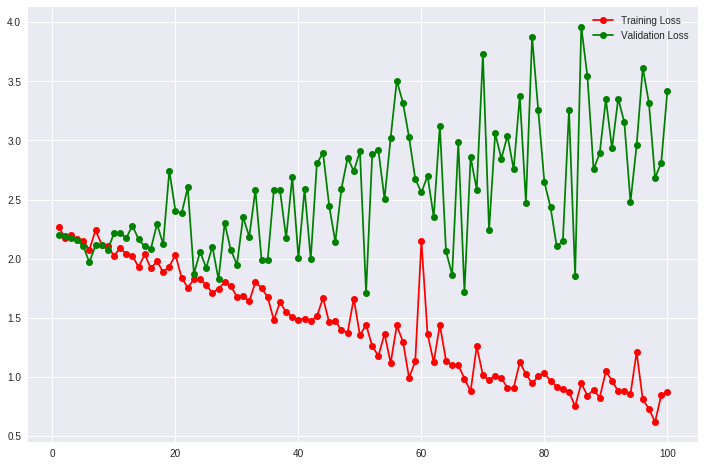

In [0]:
plt.figure(figsize=(12, 8))

loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, 101)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

### Confusion matrix

In [0]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=False, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

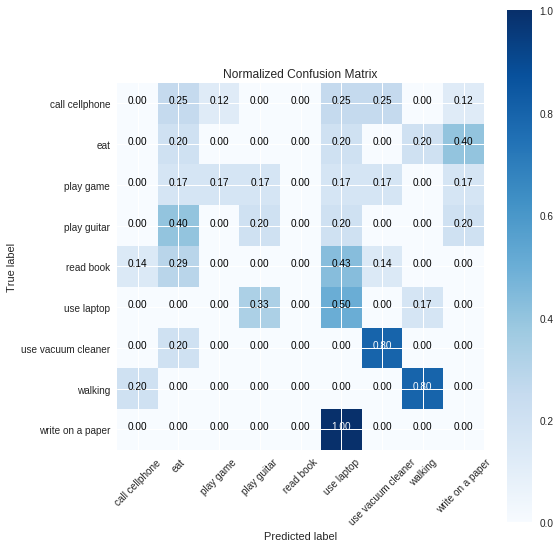

In [0]:
from sklearn.metrics import confusion_matrix

predictions = model.predict_classes(X_test)
model_cnf_matrix = confusion_matrix(test_targets, predictions)

confusion_matrix_plot = confusion_matrix_plot(model_cnf_matrix, 
                                              classes=activities.values(), 
                                              normalize=True)

## Predict

Load a custom video in order to predict using the previously trained model.

In [0]:
#@markdown Run this cell to select video to classify.

from google.colab import files
import numpy as np

os.chdir(root)
uploaded_files = files.upload()
for fname in uploaded_files.keys():
    video_name = fname
    break

Predicted class: use vacuum cleaner 

call cellphone  with probability 0.0
eat  with probability 0.0
play game  with probability 0.0
play guitar  with probability 0.0
read book  with probability 0.0
use laptop  with probability 0.0
use vacuum cleaner  with probability 1.0
walking  with probability 2.1208733e-36
write on a paper  with probability 0.0

Used video frames:


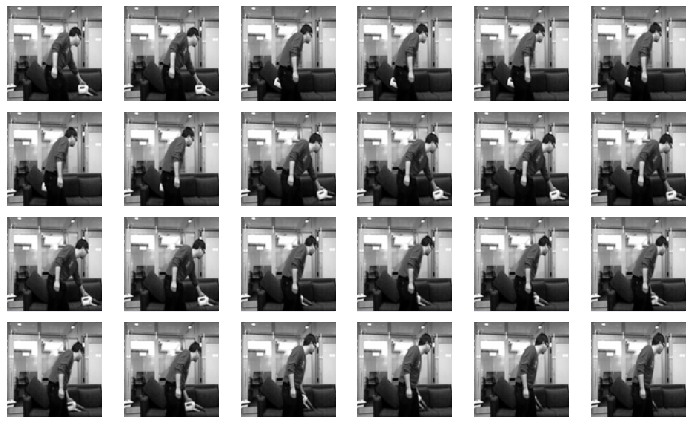

In [0]:
reader = get_reader()
X_video = reader._read_video(video_name)
X_video[0] = augment_video(X_video[0])

model = get_model()
model.load_weights('Model.weights.best.hdf5')
result = model.predict_proba(X_video)
print("Predicted class:", activities[np.argmax(result[0])], '\n')

for i in range(len(activities)):
    print(activities[i], " with probability", result[0][i])

print("\nUsed video frames:")
plot_images(X_video[0])